In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import math

<b>The functions in the cells below load and prepare data</b>
<b>Look at the [last secion](#examples) for examples </a> <b>

In [2]:
def load_x_y(data_file_name, test_split=0.20, convert_2_cat=True):
    """
    loads the training data that has been reduced by pca 
    returns the training data and labels
    """
    xs = np.load(data_file_name)
    ys = np.load('../res/training_labels.npy')
    print(ys.shape)
    print(xs.shape)
    #converting to categorical
    if convert_2_cat:
        ys = keras.utils.to_categorical(ys)

    if test_split > 0:
        x_t, x_test, y_t, y_test = train_test_split(xs, ys, test_size=test_split, shuffle=True)
        return x_t, x_test, y_t, y_test
    else:
        return xs, ys
    
def build_ys():
    """
    This function loads the labels for the training data and 
    returns the classes of each training datapoint
    used for classification witht the PCA data
    @returns a numpy array where the value at index `i` corresponds to the 
    genre of training sample i  
    """
    y_df = pd.read_csv('../res/train.csv', header=0, dtype={'new_id':str, 'genre':np.int16})
    y_df = y_df.set_index('new_id')
    file_names = os.listdir('../res/train/')
    training_labels = np.zeros(len(file_names), dtype=np.int8)
 
    for i, file_name in enumerate(file_names):
        f_name, _ = path.splitext(file_name)
        file_label = y_df.loc[f_name].genre
        training_labels[i] = file_label
    np.save('../res/training_labels', training_labels)
    return training_labels

def extract_features_build_csv(folder_path="/users/sahba/scratch/git/project3/train", csv_file="../res/train_features.csv", train_mode=True):
    """
    WARNING: Run only on clusters or powerful workstations
    Adapted from https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
    Use librosa to directly extract information from the wavefiles. Requires some music knowledge!
    if applying to training data set train_mode=False
    @param folder_path(str): the path of the training wav files
    @param csv_file(str): the path of the csv file to output the features
    @paream train_mode(boolean): if True, the labels will be appended to the csv file 
    """
    header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate rms'
    for i in range(1, 21):
        header += f' mfcc{i}'
    if train_mode:
        header += ' label'
    header = header.replace(' ', ',')
    audio_files = list(os.listdir(folder_path))
    if train_mode:
        y_df = pd.read_csv('../res/train.csv', header=0, dtype={'new_id':str, 'genre':np.int16})
        y_df = y_df.set_index('new_id')
    
    with open(csv_file, 'w') as csv_stream:
        csv_stream.write(header + "\n")
        for i, file_name in enumerate(audio_files):
            f_id, _ = path.splitext(file_name)
            if train_mode:
                file_genre = y_df.loc[f_id].genre
            y, sr = librosa.load(os.path.join(folder_path, file_name), mono=True, duration=30)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            rms = librosa.feature.rms(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{file_name} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(rms)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            if train_mode:
                to_append += f' {file_genre}'
            csv_stream.write(to_append.replace(" ", ",") + "\n")
            if i % 20 == 0:
                print(i)
def load_csv_features(csv_path='../res/train_features.csv', cat_2_num=True, shuffle=True):
    """
    reads the csv, standardize the data and converts genres to ints
    returns the standardized features and y as ints representing categories
    """
    data = pd.read_csv(csv_path)
    data = data.sample(frac=1.0)
    print(F"shape of data is {data.shape}")
    data = data.drop(['filename'], axis=1)
    scaler = StandardScaler()
    print('scaling data')
    
    #standardization: we do this so that we can use the same transform for the test set
    train_data_raw = np.array(data.iloc[:, :-1], dtype=float)
    scaler = scaler.fit(train_data_raw)
    X = scaler.transform(train_data_raw)
    genre_list = data.iloc[:, -1]
    if cat_2_num:
        encoder = LabelEncoder()
        y = encoder.fit_transform(genre_list)
    else:
        y = genre_list
    print('done with transforms')
    return X, y, scaler

def load_test_data_pca(test_data_file_name='../res/pca/test_pca_ncom40.npy', row_dict_name='../res/test_row_dict'):
    with open(row_dict_name, 'rb') as p_file:
        row_dict= pickle.load(p_file)

    eval_xs = np.load(test_data_file_name)
    return eval_xs, row_dict

***The cell below are functions for generting artifacts and performing analysis (confusion matrix/ k-fold cross_valiation)***

In [3]:
def calc_CI(score, sample_size):
    """
    Calculate and prints the confidence interval given the score and the size of the evaluation set
    resulted in that accuracy
    @param score(float)
    @param sample_size (int)
    @return the confidence interval
    """
    CI = math.sqrt(score * (1 - score)/sample_size) * 100
    print('Score: %.2f +- CI = %.2f' % (score, CI))
    return CI

def build_conf_matrix(model, x_eval, y_eval, output_file, fn_on_preds=None, fn_on_yeval=None):
    """
    given a model and and evaluation set generates the confusion matrix
    if needed a function can be passed to be applied to the result of prediction
    (such as interperating the result of one-hot-enocded results)
    saveds the confusion matrix to disk and also returns the matrix
    """
    from sklearn.metrics import confusion_matrix
    print('preparing the conf matrix')
    predictions = model.predict(x_eval)
    if fn_on_preds:
        y_pred = fn_on_preds(predictions)
    else:
        y_pred = predictions
    if fn_on_yeval:
        y_eval = fn_on_yeval(y_eval)
    # print a conf matrix and normalize each row!
    cmx = confusion_matrix(y_eval, y_pred, normalize='true')
    print(cmx)
    print('saving cmx to' + str(output_file))
    np.save(output_file, cmx)
    return cmx

def plot_conf_matrix(array_file="../res/confMat/conf_matrix.npy", conf_array=None, out_file_name="cm.png"):
    """
    given a confusion matrix as a numpy array (either saved on disk or actual array)
    plot the confusion matrix as a heatmap
    saves the heatmap in the res folder
    """
    import matplotlib
    import matplotlib.pyplot as plt

    if not conf_array:
        conf_array = np.load(array_file)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_array)
    labels = "Rock,Pop,Folk,Instr,Elec,HH".split(',')
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, "%.2f" % conf_array[i, j],ha="center", va="center", color="w")

    ax.set_title("The Confusion Matrix")
    fig.tight_layout()
    plt.savefig("../res/confMat/" + out_file_name, bbox_inches='tight', pad_inches=0.3)
    plt.show()



***The cells below implement the classifiers***

In [4]:
def DTree_Implementation(do_conf_mat=False, max_depth=None, data_type='FEATURES',
                        pca_array='../res/pca/data_pca_40.npy', plot_cm=False):
    """
    Performs decision tree classifier with either pca data or domain specific data
    can generate confusion matrix
    """
    
    
    from sklearn import tree
    if data_type.upper() == 'FEATURES':
        X, y, _ = load_csv_features(cat_2_num=False)
        x_train, x_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)
    elif data_type.upper() == 'PCA':
        x_train, x_eval, y_train, y_eval = load_x_y(pca_array, test_split=0.20, convert_2_cat=False)

    else:
        print("ERROR: unsupported data representation " + data_type)
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    eval_n = x_eval.shape[0]
    print(F"training the decision tree on {x_train.shape[0]} instances")
    clf = clf.fit(x_train, y_train)
    print(F"Decision Tree fit is complete, the depth is {clf.get_depth()}"
          + "and the score on training set is:")
    print(clf.score(x_train, y_train))
    print(F"and on the eval set {eval_n} instances:")
    clf_score = clf.score(x_eval, y_eval)
    calc_CI(clf_score, x_eval.shape[0])
    if do_conf_mat:
        array_dst = F'../res/confMat/dt_cm_{str(max_depth)}'
        build_conf_matrix(clf, x_eval, y_eval, array_dst)
        if plot_cm:
            plot_conf_matrix(array_file=array_dst + ".npy", conf_array=None, out_file_name=F"dt_cm_{str(max_depth)}" + ".png")
            
    return clf_score

def build_model(input_dim=40, loss='categorical_crossentropy'):
    model = keras.models.Sequential()
    model.add(layers.BatchNormalization(input_shape=(input_dim,)))
    model.add(layers.Dense(60, input_dim=input_dim))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.15))
    #model.add(layers.BatchNormalization())

    #layer2
    model.add(layers.Dense(100))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    #layer 3
    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.15))
    model.add(layers.BatchNormalization())
    
    #layer 4
    #model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    #output layer
    model.add(layers.Dense(6, activation='softmax'))
    optimizer_sgd = keras.optimizers.SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer_adam = keras.optimizers.Adam(learning_rate=0.003)
    model.compile(loss=loss, optimizer=optimizer_sgd, metrics=['accuracy'])
    return model

**The cells below use the functions above to actually do the training and evaluation**

In [5]:
def load_csv_train_NN(csv_path, input_dim=40, do_conf_mat=False):
    """"
    loads a csv of filename, extracted features, label and trains the model on it
    Will print the confusion matrix if do_conf_mat is True
    returns the trained model along with the scaler used to standardize the data
    """
    X, y, scaler = load_csv_features(csv_path)
    x_train, x_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)

    print(F"\nusing {x_train.shape[0]} training samples\n")

    y_onehot_train = keras.utils.to_categorical(y_train)
    y_onehot_eval = keras.utils.to_categorical(y_eval)
    
    #building the model and training
    model = build_model(input_dim=input_dim)
    model.fit(x_train, y_onehot_train, epochs=100, batch_size=64, validation_data=(x_eval, y_onehot_eval))
    result = model.evaluate(x_eval, y_onehot_eval)
    calc_CI(result[-1], x_eval.shape[0])
    #prepare the confusion matrix if requested
    if do_conf_mat:
        from sklearn.metrics import confusion_matrix
        print('preparing the conf matrix')
        predictions = model.predict(x_eval)
        y_pred = [np.argmax(predictions[r]) for r in range(predictions.shape[0])]
        # print a conf matrix and normalize each row!
        cmx = confusion_matrix(y_eval, y_pred, normalize='true')
        print(cmx)
        np.save('../res/conf_matrix', cmx)
    return model, scaler


def predict_kaggle_feature(train_csv="../res/train_features.csv", test_csv='../res/test_features.csv', output_csv='kaggle_feature.csv'):
    """
    Trains the model based on the features extracted from the training files
    and uses them to classify the test set
    writes the prediction to ./kaggle_features.csv by default
    """
    #using the same scaler to transform the test set
    model, scaler = load_csv_train_NN(train_csv, input_dim=26)
    test_data = pd.read_csv(test_csv)
    file_names = test_data['filename']
    test_data = test_data.drop(['filename'], axis=1)
    x_test = scaler.transform(np.array(test_data, dtype=np.float))
    predictions = model.predict(x_test)
    with open(output_csv, 'w') as csv_stream:
        csv_stream.write('id,genre\n')
        for r in range(predictions.shape[0]):
            predicted_genre = np.argmax(predictions[r, :])
            file_label, _ = path.splitext(file_names.iloc[r])
            csv_stream.write(f"{file_label},{predicted_genre}\n")
            
            
def nn_with_pca(pca_array='../res/pca/data_pca_40.npy', num_comp=40, do_conf_mat=False, do_kfold=0):
    """
    Trains a neural network using the pca data
    can do k-fold and/or produce confusion matrix
    """
    if do_kfold > 1:
        from sklearn.model_selection import StratifiedKFold
        seed = 17
        kfold = StratifiedKFold(n_splits=do_kfold, shuffle=True, random_state=seed)
        csv_scores = np.zeros(do_kfold)
        X = np.load(pca_array)
        y = np.load('../res/training_labels.npy')
        print(f'started {do_kfold}-folds validation. keeping {len(X)} for evaluation')
        for i,(train, test) in enumerate(kfold.split(X, y)):
            y_train = keras.utils.to_categorical(y[train])
            y_test = keras.utils.to_categorical(y[test])
            model = build_model(input_dim=num_comp)
            model.fit(X[train], y_train, epochs=100, batch_size=64, verbose=False)
            result = model.evaluate(X[test], y_test, verbose=False)
            score = result[-1] * 100
            print("%s: %.2f%%" % (model.metrics_names[1], score))
            csv_scores[i] = score
        print("average: %.2f%% +- %.2f%%" % (csv_scores.mean(), csv_scores.std()))

    x_train, x_eval, y_train, y_eval = load_x_y(pca_array, 0.2)
    model = build_model(input_dim=num_comp)
    "given the training and evbaluation data, trains the model"  
    history = model.fit(x_train, y_train, epochs=100, batch_size=64)
    score = model.evaluate(x_eval, y_eval)[-1]
    calc_CI(score, x_eval.shape[0])
    cat_2_num = lambda x: [np.argmax(r) for r in x]
    if do_conf_mat:
        build_conf_matrix(model, x_eval, y_eval, F'../res/pca_cm_{str(num_comp)}', cat_2_num, cat_2_num)
        

def nn_cross_val(csv_path, input_dim = 26, folds=5):
    """
    cross validation for the neural network based on features
    adapted from:
    https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
    """
    from sklearn.model_selection import StratifiedKFold
    seed = 17
    X, y, _ = load_csv_features(csv_path)
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    csv_scores = np.zeros(folds)
    print(f'started {folds}-folds training')
    print(y.shape)
    for i,(train, test) in enumerate(kfold.split(X, y)):
        y_train = keras.utils.to_categorical(y[train])
        y_test = keras.utils.to_categorical(y[test])
        model = build_model(input_dim=input_dim)
        model.fit(X[train], y_train, epochs=150, batch_size=64, verbose=False)
        result = model.evaluate(X[test], y_test, verbose=False)
        score = result[-1] * 100
        print("%s: %.2f%%" % (model.metrics_names[1], score))
        csv_scores[i] = score
    print("average: %.2f%% +- %.2f%%" % (csv_scores.mean(), csv_scores.std()))
    
    
def train_for_kaggle_pca():
    model = build_model()
    x_train,x_eval, y_train,y_eval = load_x_y('../res/pca/data_pca_40.npy', test_split=0.1)
    model.fit(x_train, y_train, epochs=300, batch_size=64, validation_data=(x_eval, y_eval))
    x_test, row_dict = load_test_data_pca()
    predictions = model.predict(x_test)
    with open('kaggle.csv', 'w') as csv_stream:
        csv_stream.write('id,genre\n')
        for r in range(predictions.shape[0]):
            predicted_genre = np.argmax(predictions[r,:])
            file_label = row_dict[r]
            csv_stream.write(f"{file_label},{predicted_genre}\n")




<a id="examples"></a>
<h2>EXAMPLES: The cells below run the whole pipeline for different classifications</h2>


shape of data is (2400, 28)
scaling data
done with transforms
training the decision tree on 1920 instances
Decision Tree fit is complete, the depth is 10and the score on training set is:
0.8119791666666667
and on the eval set 480 instances:
Score: 0.36 +- CI = 2.19
preparing the conf matrix
[[0.3625     0.2625     0.025      0.0875     0.1375     0.125     ]
 [0.16494845 0.29896907 0.11340206 0.12371134 0.15463918 0.1443299 ]
 [0.08       0.14666667 0.41333333 0.28       0.06666667 0.01333333]
 [0.11428571 0.15714286 0.18571429 0.42857143 0.07142857 0.04285714]
 [0.11267606 0.1971831  0.07042254 0.07042254 0.26760563 0.28169014]
 [0.12643678 0.17241379 0.03448276 0.09195402 0.17241379 0.40229885]]
saving cmx to../res/confMat/dt_cm_10


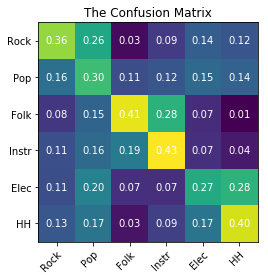

0.36041666666666666

In [6]:
#running Dtree with domain features
DTree_Implementation(max_depth=10, do_conf_mat=True, plot_cm=True, data_type="FEATURES")

(2400,)
(2400, 40)
training the decision tree on 1920 instances
Decision Tree fit is complete, the depth is 10and the score on training set is:
0.5947916666666667
and on the eval set 480 instances:
Score: 0.23 +- CI = 1.91
preparing the conf matrix
[[0.17391304 0.1884058  0.36231884 0.10144928 0.11594203 0.05797101]
 [0.13333333 0.04       0.41333333 0.10666667 0.13333333 0.17333333]
 [0.18888889 0.05555556 0.63333333 0.05555556 0.03333333 0.03333333]
 [0.13095238 0.13095238 0.48809524 0.05952381 0.05952381 0.13095238]
 [0.24657534 0.1369863  0.19178082 0.05479452 0.17808219 0.19178082]
 [0.20224719 0.13483146 0.12359551 0.16853933 0.15730337 0.21348315]]
saving cmx to../res/confMat/dt_cm_10


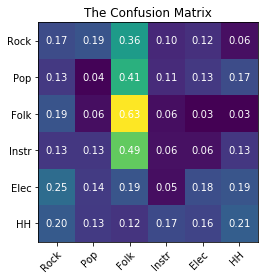

0.22708333333333333

In [7]:
#running Dtree with domain features
DTree_Implementation(max_depth=10, do_conf_mat=True, plot_cm=True, data_type="PCA")

In [8]:
# training neural network with domain-specific fetures
load_csv_train_NN('../res/train_features.csv', do_conf_mat=False, input_dim=26)

shape of data is (2400, 28)
scaling data
done with transforms

using 1920 training samples

Train on 1920 samples, validate on 480 samples
Epoch 1/100
1920/1920 [==============================] - 3s 2ms/sample - loss: 1.9351 - accuracy: 0.2578 - val_loss: 1.5927 - val_accuracy: 0.4104
Epoch 2/100
1920/1920 [==============================] - 0s 245us/sample - loss: 1.6543 - accuracy: 0.3547 - val_loss: 1.5085 - val_accuracy: 0.4271
Epoch 3/100
1920/1920 [==============================] - 0s 246us/sample - loss: 1.5462 - accuracy: 0.3922 - val_loss: 1.4668 - val_accuracy: 0.4208
Epoch 4/100
1920/1920 [==============================] - 0s 248us/sample - loss: 1.5067 - accuracy: 0.4078 - val_loss: 1.4345 - val_accuracy: 0.4396
Epoch 5/100
1920/1920 [==============================] - 1s 272us/sample - loss: 1.4894 - accuracy: 0.4031 - val_loss: 1.4136 - val_accuracy: 0.4417
Epoch 6/100
1920/1920 [==============================] - 0s 254us/sample - loss: 1.4822 - accuracy: 0.4057 - val_loss:

Epoch 55/100
1920/1920 [==============================] - 0s 189us/sample - loss: 1.2897 - accuracy: 0.4974 - val_loss: 1.2835 - val_accuracy: 0.4875
Epoch 56/100
1920/1920 [==============================] - 0s 259us/sample - loss: 1.2995 - accuracy: 0.4839 - val_loss: 1.2834 - val_accuracy: 0.4833
Epoch 57/100
1920/1920 [==============================] - 0s 232us/sample - loss: 1.2783 - accuracy: 0.4995 - val_loss: 1.2801 - val_accuracy: 0.4708
Epoch 58/100
1920/1920 [==============================] - 0s 191us/sample - loss: 1.2681 - accuracy: 0.4969 - val_loss: 1.2812 - val_accuracy: 0.4812
Epoch 59/100
1920/1920 [==============================] - 0s 125us/sample - loss: 1.2754 - accuracy: 0.4979 - val_loss: 1.2800 - val_accuracy: 0.4812
Epoch 60/100
1920/1920 [==============================] - 0s 96us/sample - loss: 1.2580 - accuracy: 0.5099 - val_loss: 1.2813 - val_accuracy: 0.4854
Epoch 61/100
1920/1920 [==============================] - 0s 184us/sample - loss: 1.2750 - accuracy: 

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f2b7d009208>,
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [12]:
# training neural network with PCA. set do_kfols to a number like 5 for cross validation
nn_with_pca(do_conf_mat=True, do_kfold=0)

(2400,)
(2400, 40)
Train on 1920 samples
Epoch 1/100
1920/1920 [==============================] - 1s 726us/sample - loss: 2.2035 - accuracy: 0.1578
Epoch 2/100
1920/1920 [==============================] - 0s 178us/sample - loss: 1.9703 - accuracy: 0.1932
Epoch 3/100
1920/1920 [==============================] - 0s 173us/sample - loss: 1.8885 - accuracy: 0.2188
Epoch 4/100
1920/1920 [==============================] - 0s 160us/sample - loss: 1.8571 - accuracy: 0.2250
Epoch 5/100
1920/1920 [==============================] - 0s 137us/sample - loss: 1.8304 - accuracy: 0.2250
Epoch 6/100
1920/1920 [==============================] - 0s 144us/sample - loss: 1.7981 - accuracy: 0.2339
Epoch 7/100
1920/1920 [==============================] - 1s 274us/sample - loss: 1.7774 - accuracy: 0.2276
Epoch 8/100
1920/1920 [==============================] - 0s 204us/sample - loss: 1.7660 - accuracy: 0.2438
Epoch 9/100
1920/1920 [==============================] - 0s 167us/sample - loss: 1.7511 - accuracy: 0.2

In [9]:
#cross validation with neural networks 
nn_cross_val('../res/train_features.csv')

shape of data is (2400, 28)
scaling data
done with transforms
started 5-folds training
(2400,)
accuracy: 53.75%
accuracy: 56.04%
accuracy: 48.33%
accuracy: 51.88%
accuracy: 53.33%
average: 52.67% +- 2.55%
